In [87]:
import os
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.cuda.amp import autocast, GradScaler

# --------------------- Dataset Definition ---------------------
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.root = image_dir
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        boxes, labels = [], []
        for ann in anns:
            if ann['bbox'][2] > 0 and ann['bbox'][3] > 0:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(ann['category_id'])

        if len(boxes) == 0:
            return self.__getitem__((index + 1) % len(self.ids))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.ids)

# --------------------- Transforms ---------------------
transform = T.Compose([
    T.Resize((384, 384)),  # Slightly smaller
    T.ToTensor()
])

# --------------------- Model Definition ---------------------
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# --------------------- Setup ---------------------
image_dir = "/home/divya/CHILLIE/dataset/images"
annotation_file = "/home/divya/CHILLIE/dataset/annotations/converted_coco_annotations.json"
dataset = COCODataset(image_dir, annotation_file, transforms=transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2)
model = torch.nn.DataParallel(model)  # Simplified multi-GPU use
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scaler = GradScaler()

# --------------------- Training Loop ---------------------
num_epochs = 1
accumulation_steps = 4

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with autocast():  # Mixed precision
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()

        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += losses.item()

        del images, targets, loss_dict, losses
        torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


/tmp/ipykernel_153177/3835663110.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_153177/3835663110.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Epoch [1/1], Loss: nan


In [90]:
torch.save(model.state_dict(), "/home/divya/CHILLIE/models/mymodel.pth")


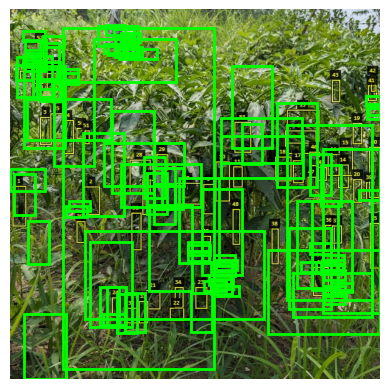

Predicted Chili Count: 100


In [93]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model and move it to the correct device
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=2)  # background + chili
model.load_state_dict(torch.load("/home/divya/CHILLIE/models/mymodel.pth"))
model.to(device)
model.eval()


# Load image
image_dir = "/home/divya/CHILLIE/6"
image_name = "6_original.jpg"  # change if needed
img_path = os.path.join(image_dir, image_name)
img = Image.open(img_path).convert("RGB")

# Apply transformations and move image to the same device
img_tensor = get_transform()(img).to(device)

# Run inference
with torch.no_grad():
    prediction = model([img_tensor])[0]

# Set detection threshold
threshold = 0.3

# Count number of detected chilies
chili_count = sum(score.item() > threshold for score in prediction['scores'])

# Visualize predictions
plt.imshow(img)
ax = plt.gca()
for box, score in zip(prediction['boxes'], prediction['scores']):
    if score > threshold:
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

plt.axis("off")
plt.show()

print("Predicted Chili Count:", chili_count)


In [2]:
# --------- 1. Training Script with Improvements ---------
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Dataset Definition
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.root = image_dir
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        boxes, labels = [], []
        for ann in anns:
            if ann['bbox'][2] > 0 and ann['bbox'][3] > 0:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(ann['category_id'])

        if len(boxes) == 0:
            return self.__getitem__((index + 1) % len(self.ids))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.ids)

# Transformations
train_transform = T.Compose([
    T.Resize((384, 384)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor()
])

inference_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor()
])

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Setup
image_dir = "/home/divya/CHILLIE/dataset/images"
annotation_file = "/home/divya/CHILLIE/dataset/annotations/converted_coco_annotations.json"
dataset = COCODataset(image_dir, annotation_file, transforms=train_transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2)
model = torch.nn.DataParallel(model)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scaler = GradScaler()

# Training Loop
num_epochs = 15
accumulation_steps = 4
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()

        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += losses.item()

        del images, targets, loss_dict, losses
        torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

  

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


/tmp/ipykernel_269124/1848029341.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_269124/1848029341.py:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/15], Loss: nan
Epoch [2/15], Loss: nan
Epoch [3/15], Loss: nan
Epoch [4/15], Loss: nan
Epoch [5/15], Loss: nan
Epoch [6/15], Loss: nan
Epoch [7/15], Loss: nan
Epoch [8/15], Loss: nan
Epoch [9/15], Loss: nan
Epoch [10/15], Loss: nan
Epoch [11/15], Loss: nan
Epoch [12/15], Loss: nan
Epoch [13/15], Loss: nan
Epoch [14/15], Loss: nan
Epoch [15/15], Loss: nan


In [3]:
torch.save(model.state_dict(), "/home/divya/CHILLIE/models/model1.pth")

In [13]:
torch.save(model.state_dict(), "/home/divya/CHILLIE/models/best_model.pth")

In [ ]:
torch.save(model.state_dict(), "/home/divya/CHILLIE/models/mymodel.pth")

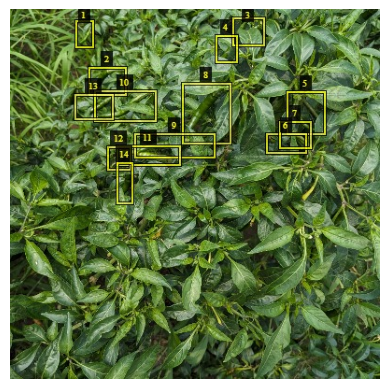

Predicted Chili Count: 0


In [ ]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model and move it to the correct device
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=2)  # background + chili
model.load_state_dict(torch.load("/home/divya/CHILLIE/models/best_model.pth"))
model.to(device)
model.eval()


# Load image
image_dir = "/home/divya/CHILLIE/dataset/images"
image_name = "74_original.jpg"  # change if needed
img_path = os.path.join(image_dir, image_name)
img = Image.open(img_path).convert("RGB")

# Apply transformations and move image to the same device
img_tensor = get_transform()(img).to(device)

# Run inference
with torch.no_grad():
    prediction = model([img_tensor])[0]

# Set detection threshold
threshold = 0.3

# Count number of detected chilies
chili_count = sum(score.item() > threshold for score in prediction['scores'])

# Visualize predictions
plt.imshow(img)
ax = plt.gca()
for box, score in zip(prediction['boxes'], prediction['scores']):
    if score > threshold:
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

plt.axis("off")
plt.show()

print("Predicted Chili Count:", chili_count)


In [17]:
torch.save(model, "model1_full.pth")


In [22]:
torch.save(model.state_dict(), "/home/divya/CHILLIE/models/model2_full.pth")


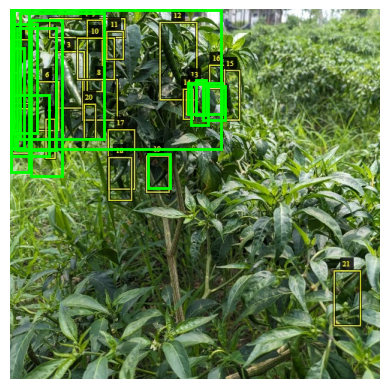

Predicted Chili Count: 13


In [45]:
import os
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define transform
def get_transform():
    return T.Compose([T.ToTensor()])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Recreate the same model structure (important: pretrained=True)
model = fasterrcnn_resnet50_fpn(pretrained=True)  # <-- change here
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)  # 2 = background + chili

# Step 2: Load the saved model weights (state_dict)
model.load_state_dict(torch.load("/home/divya/CHILLIE/models/model2_full.pth", map_location=device))
model.to(device)
model.eval()

# Step 3: Load and transform the image
image_dir = "/home/divya/CHILLIE/dataset/images"
image_name = "44_original.jpg"  # change if needed
img_path = os.path.join(image_dir, image_name)
img = Image.open(img_path).convert("RGB")
img_tensor = get_transform()(img).to(device)

# Step 4: Run inference
with torch.no_grad():
    prediction = model([img_tensor])[0]

# Step 5: Count detected chilies
threshold = 0.58
chili_count = sum(score.item() > threshold for score in prediction['scores'])

# Step 6: Visualize detections
plt.imshow(img)
ax = plt.gca()
for box, score in zip(prediction['boxes'], prediction['scores']):
    if score > threshold:
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

plt.axis("off")
plt.show()

print("Predicted Chili Count:", chili_count)


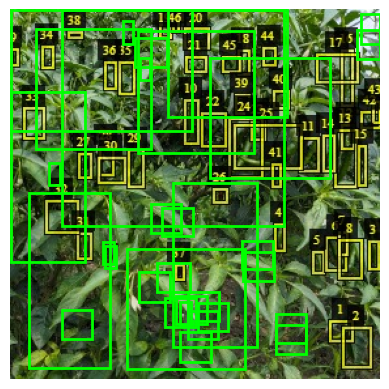

Predicted Chili Count: 34


In [58]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model and move it to the correct device
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=2)  # background + chili
model.load_state_dict(torch.load("/home/divya/CHILLIE/models/mymodel.pth"))
model.to(device)
model.eval()


# Load image
image_dir = "/home/divya/CHILLIE/dataset/images"
image_name = "59_original.jpg"  # change if needed
img_path = os.path.join(image_dir, image_name)
img = Image.open(img_path).convert("RGB")

# Apply transformations and move image to the same device
img_tensor = get_transform()(img).to(device)

# Run inference
with torch.no_grad():
    prediction = model([img_tensor])[0]

# Set detection threshold
threshold = 0.51

# Count number of detected chilies
chili_count = sum(score.item() > threshold for score in prediction['scores'])

# Visualize predictions
plt.imshow(img)
ax = plt.gca()
for box, score in zip(prediction['boxes'], prediction['scores']):
    if score > threshold:
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

plt.axis("off")
plt.show()

print("Predicted Chili Count:", chili_count)
